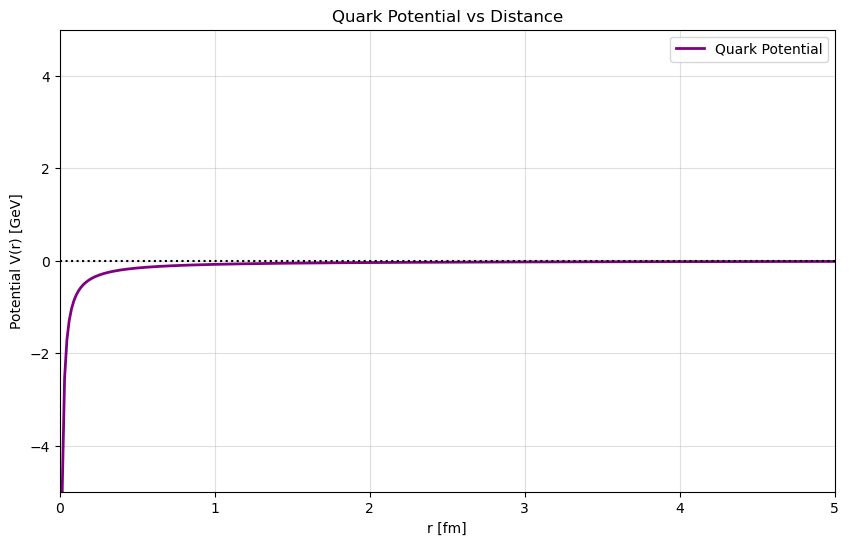

Saved potential plot to wavefunction_results/quark_potential.png
Saved potential data to wavefunction_results/quark_potential.dat


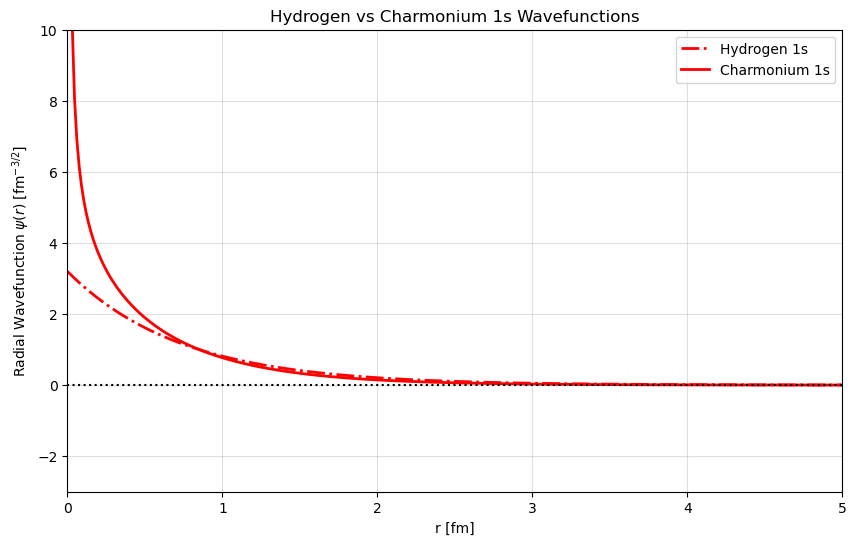

1s Normalization - Hydrogen: 1.000000, Charmonium: 0.999747
Saved data and plot for 1s state to wavefunction_results/


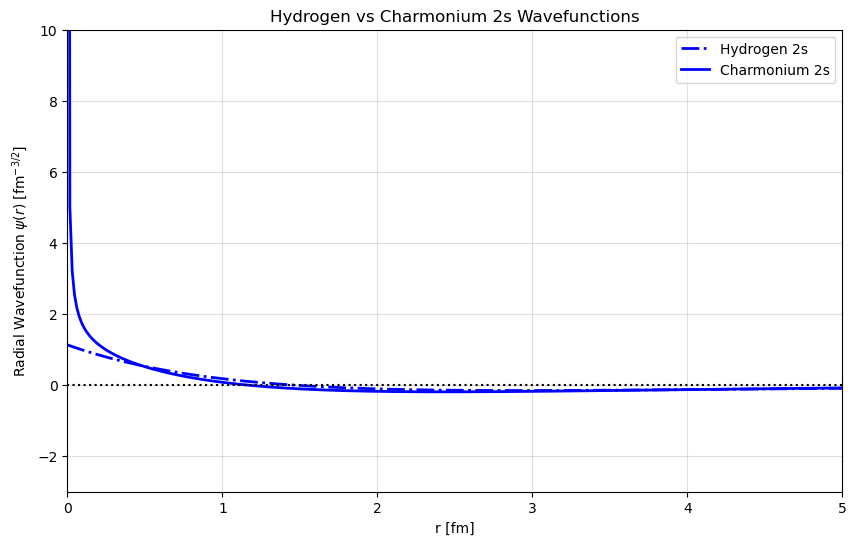

2s Normalization - Hydrogen: 1.000000, Charmonium: 0.999975
Saved data and plot for 2s state to wavefunction_results/


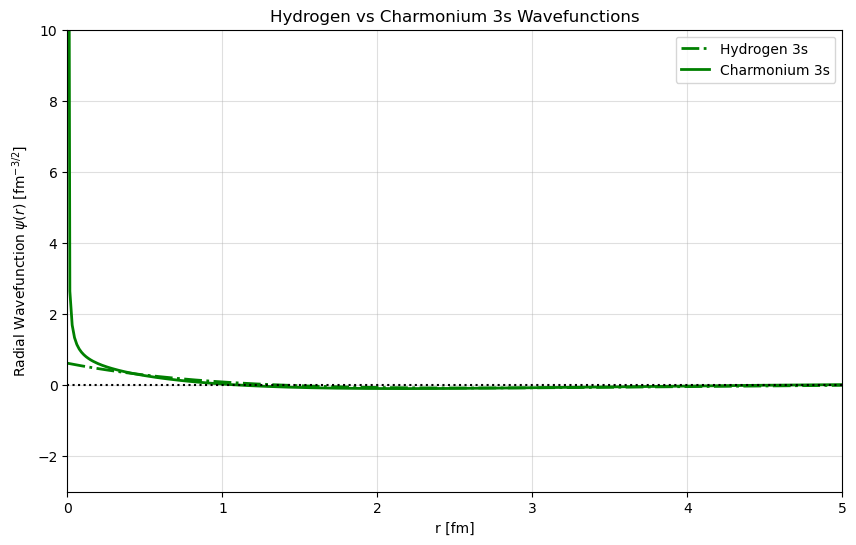

3s Normalization - Hydrogen: 1.000000, Charmonium: 0.999993
Saved data and plot for 3s state to wavefunction_results/
All results saved in directory as (r , $\psi(r)$): /Users/mohammadyousuf/Desktop/ML_QQ_codes/ML_code_QQ/wavefunction_results


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre
import math
import os

# Constants
hbar = 0.19732  # GeV·fm
sigma = 0.184   # GeV^2
xmin, xmax = 0.001, 30.0  # Range
interval = 2001  # Higher resolution

# Create output directory if it doesn't exist
output_dir = "wavefunction_results"
os.makedirs(output_dir, exist_ok=True)

# Charmonium parameters
mc = 1.35  # GeV  For beauty quark m = 4.7
mcr = mc / 2.0
alpha_s = 0.3 # can be taken temperature dependent
cf = 4/3 # Casimir Factor (summation of colors)
a0 = hbar / (mcr * cf * alpha_s)  # Quarkonia's Bohr radius

# Radial grid for hydrogen
r_values = np.linspace(0.001, 30.0, 2000)  # Fine grid for accurate integration
dr = r_values[1] - r_values[0]

# Original hydrogen wavefunctions (radial ones)
def psi_1s(r, a0):
    return (1 / np.sqrt(np.pi * a0**3)) * np.exp(-r / a0)

def psi_2s(r, a0):
    return (1 / np.sqrt(8 * np.pi * a0**3)) * (1 - r / (2 * a0)) * np.exp(-r / (2 * a0))

def psi_3s(r, a0):
    term1 = (1 - (2 * r) / (3 * a0))
    term2 = (2 * r**2) / (27 * a0**2)
    return (1 / np.sqrt(27 * np.pi * a0**3)) * (term1 + term2) * np.exp(-r / (3 * a0))

# Renormalization functions (since a0 is set according to Quarkonia, we have renormalized again)
def get_normalized_wavefunction(psi_func, a0, r_grid):
    psi_unnorm = psi_func(r_grid, a0)
    integrand = psi_unnorm**2 * r_grid**2
    norm = np.sqrt(np.trapz(integrand, r_grid))
    return psi_unnorm / norm

# Get normalized wavefunctions
psi1s_norm = get_normalized_wavefunction(psi_1s, a0, r_values)
psi2s_norm = get_normalized_wavefunction(psi_2s, a0, r_values)
psi3s_norm = get_normalized_wavefunction(psi_3s, a0, r_values)

# Schrodinger solver class (our calculation for Quarkonia)
class Schrodinger:
    def __init__(self, V_re_func, mass, hbar, xmin, xmax, ninterval):
        self.r = np.linspace(xmin, xmax, ninterval)
        self.dr = self.r[1] - self.r[0]
        self.mass = mass
        self.U = np.diag(V_re_func(self.r), 0)
        self.Lap = self.laplacian(ninterval)
        self.H = -hbar**2/(2.0*mass)*self.Lap + self.U 
        # to add relativistic corrections,you need to add (m1 + m2). in quarkonia m1=m2=m. So add +2.0*self.mass
        self.eigE, self.eigV = self.eig_solve()

    # using finite differrence method
    def laplacian(self, N):
        return (-2*np.diag(np.ones(N)) + np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1))/(self.dr**2)

    def eig_solve(self):
        w, v = np.linalg.eigh(self.H)
        for i in range(v.shape[1]):
            if v[1,i] < 0:
                v[:,i] *= -1
        return np.sort(w), v[:, np.argsort(w)]

    def normalize_radial_wavefunction(self, R_r):
        integrand = np.abs(R_r)**2 * self.r**2
        norm = np.sqrt(np.sum(integrand) * self.dr)
        return R_r / norm

    def radial_wavefunction(self, n=0):
        u_n = self.eigV[:, n]
        R_r = np.where(self.r > 0, u_n/self.r, u_n[1]/self.r[1])
        return self.normalize_radial_wavefunction(R_r)

# Coulom potential for check
def quark_potential(r):
    r = np.where(r < 0.001, 0.001, r)
    hbar = 0.197
    s = r / hbar #unit conversion in GeV^-1
    return -cf * alpha_s / s  # potential in GeV

# # For Qurkonia use Cornell Potential function (Coulomb + linear)
# def quark_potential(r):
#     r = np.where(r < 0.001, 0.001, r)
#     hbar = 0.197
#     s = r / hbar
#     return -cf * alpha_s / s + sigma * s  # Change this potential with medium modified potential



# Initialize and solve
sch = Schrodinger(quark_potential, mass=mcr, hbar=hbar,
                xmin=xmin, xmax=xmax, ninterval=interval)


# Calculate potential values
potential_r = sch.r  # Using the same radial grid as the Schrodinger solver
potential_values = quark_potential(potential_r)


# Plot potential
plt.figure(figsize=(10, 6))
plt.plot(potential_r, potential_values, label='Quark Potential', color='purple', linewidth=2)
plt.axhline(0, color='k', linestyle=':')
plt.xlabel(r"r [fm]")
plt.ylabel(r"Potential V(r) [GeV]")
plt.title("Quark Potential vs Distance")
plt.grid(True, alpha=0.4)
plt.xlim(0, 5)
plt.legend()

# Save potential plot
potential_plot_filename = os.path.join(output_dir, "quark_potential.png")
plt.savefig(potential_plot_filename, dpi=300, bbox_inches='tight')
plt.xlim(0,5)
plt.ylim(-5,5)
plt.show()
plt.close()

# Save potential data in {x,y} format
potential_filename = os.path.join(output_dir, "quark_potential.dat")
with open(potential_filename, 'w') as f:
    for r, v in zip(potential_r, potential_values):
        f.write(f"{{{r:.6f},{v:.6f}}}\n")

print(f"Saved potential plot to {potential_plot_filename}")
print(f"Saved potential data to {potential_filename}")


# Get quarkonia wavefunctions
R_q1 = sch.radial_wavefunction(n=0)
R_q2 = sch.radial_wavefunction(n=1)
R_q3 = sch.radial_wavefunction(n=2)

# Create individual plots and save data for each state
states = [
    (0, '1s', psi1s_norm, R_q1, 'red'),
    (1, '2s', psi2s_norm, R_q2, 'blue'),
    (2, '3s', psi3s_norm, R_q3, 'green')
]

for n, state_name, psi_h, psi_q, color in states:
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(r_values, psi_h, label=f'Hydrogen {state_name}', 
             color=color, linestyle='-.', linewidth=2)
    plt.plot(sch.r, psi_q, label=f'Charmonium {state_name}', 
             color=color, linestyle='-', linewidth=2)
    
    plt.axhline(0, color='k', linestyle=':')
    plt.xlabel(r"r [fm]")
    plt.ylabel(r"Radial Wavefunction $\psi(r)$ [fm$^{-3/2}$]")
    plt.title(f"Hydrogen vs Charmonium {state_name} Wavefunctions")
    plt.grid(True, alpha=0.4)
    plt.xlim(0, 5)
    ymax = max(np.max(np.abs(psi_h)), np.max(np.abs(psi_q))) * 1.1
    plt.ylim(-3, 10)
    plt.legend()

    # data will be saven in a folder where code is downloaded
    # Save plot
    plot_filename = os.path.join(output_dir, f"wavefunction_{state_name}.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    
    # Save data to .dat files # you can change the format to .csv, .txt, etc
    # Hydrogen data
    hydrogen_data = np.column_stack((r_values, psi_h))
    hydrogen_filename = os.path.join(output_dir, f"hydrogen_{state_name}.dat")
    np.savetxt(hydrogen_filename, hydrogen_data, fmt='%.6f')
    
    # Charmonium data
    charmonium_data = np.column_stack((sch.r, psi_q))
    charmonium_filename = os.path.join(output_dir, f"charmonium_{state_name}.dat")
    np.savetxt(charmonium_filename, charmonium_data, fmt='%.6f')

    # Print normalization info
    norm_h = np.trapz(psi_h**2 * r_values**2, r_values)
    norm_q = np.trapz(psi_q**2 * sch.r**2, sch.r) 
    print(f"{state_name} Normalization - Hydrogen: {norm_h:.6f}, Charmonium: {norm_q:.6f}")
    print(f"Saved data and plot for {state_name} state to {output_dir}/")

print(f"All results saved in directory as (r , $\psi(r)$): {os.path.abspath(output_dir)}")